<a href="https://colab.research.google.com/github/paotabetai/NLP100/blob/master/C8_Neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## 同一ディレクトリ内にhttps://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?resourcekey=0-wjGZdNAUop6WykTtMip30g からダウンロードした学習済み単語ベクトルを配置しているものとする

from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from gensim.models import KeyedVectors

DATASETPATH = '/content/drive/MyDrive/Colab Notebooks/NLP100/GoogleNews-vectors-negative300.bin' 

wv = KeyedVectors.load_word2vec_format(DATASETPATH, binary=True)

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip

--2023-04-02 08:10:40--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29224203 (28M) [application/x-httpd-php]
Saving to: ‘NewsAggregatorDataset.zip’

NewsAggregatorDatas 100%[===================>]  27.87M  35.0MB/s    in 0.8s    

2023-04-02 08:10:41 (35.0 MB/s) - ‘NewsAggregatorDataset.zip’ saved [29224203/29224203]



In [ ]:
!unzip NewsAggregatorDataset.zip

Archive:  NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   


In [ ]:
# 50
import collections
import csv
import random

TARGET_PUBLISHERS = [
  'Reuters',\
  'Huffington Post',\
  'Businessweek',\
  'Contactmusic.com',\
  'Daily Mail'
]

CATEGORIES = [
    'b',
    't',
    'e',
    'm'
]

with open('./newsCorpora.csv') as f:
  reader = csv.reader(f, delimiter='\t')
  all_news = [[news[4], news[1]] for news in reader if news[3] in TARGET_PUBLISHERS]

random.shuffle(all_news)

train_data_num = len(all_news)  * 8 // 10
valid_data_num = len(all_news)  * 9 // 10
train_data = all_news[: train_data_num]
valid_data = all_news[train_data_num : valid_data_num]
test_data = all_news[valid_data_num :]

In [ ]:
# 70
import numpy as np


NEWS_CATEGORIES = {
    'b' : 0,
    't' : 1,
    'e' : 2,
    'm' : 3
}


def vector_create(X, filepath):
  for news in X:
    title, category = news[1], news[0]
    word_v = None
    for word in title.split(' '):
      if word:
        N = 0
        try:
          if word_v:
            word_v = word_v + wv[word] #. most_similarで抽出しようとするとメモリが死ぬため、データセットに存在する場合のみ扱う
            N += 1
          else:
            word_v = wv[word]
            N = 1
        except:
          continue
    if word_v is None:
      word_v = np.zeros(300)
    with open(f'./{filepath}_x.csv', mode='a') as f:
      if N != 0:
        word_v = word_v / N
      f.write(str(','.join(list([str(char) for char in word_v]))) + '\n')
    y = NEWS_CATEGORIES[news[0]]
    with open(f'./{filepath}_y.csv', mode='a') as f:
      f.write(str(y) + '\n')

vector_create(train_data, 'train')
vector_create(valid_data, 'valid')
vector_create(test_data, 'test')

In [ ]:
# 71
import csv
from scipy.special import softmax


X_14 = []
with open(f'./train_x.csv', mode='r') as f:
  data = csv.reader(f)
  i = 0
  for row in data:
    if i == 4:
      break
    X_14.append(row)
    i += 1
  X_14 = np.array(X_14, dtype=np.float64)

d = X_14.shape[1]
L = len(NEWS_CATEGORIES)
W = np.random.rand(d, L)

y_hat1 = softmax(np.dot(X_14[0], W))
print(f'y_hat1: {y_hat1}')

Y_hat = np.dot(X_14, W)

for i in range(L):
  Y_hat[i] = softmax(Y_hat[i])
print(f'Y_hat: {Y_hat}')


y_hat1: [0.06698071 0.0670067  0.83055465 0.03545794]
Y_hat: [[0.06698071 0.0670067  0.83055465 0.03545794]
 [0.30845665 0.43087894 0.16478007 0.09588434]
 [0.60951493 0.03273624 0.07605344 0.28169538]
 [0.11316709 0.60820541 0.17452932 0.10409818]]


In [ ]:

# 72
Y_14 = []
with open(f'./train_y.csv', mode='r') as f:
  data = f.readlines()
  i = 0
  for row in data:
    if i == 4:
      break
    y = int(row.strip())
    Y = np.zeros(L)
    Y[y] = 1
    Y_14.append(Y)
    i += 1
Y_14 = np.array(Y_14)
p1 = np.dot(Y_hat[0], Y_14[0])

l1 =  -1 * np.log(p1)
print(f'l1: {l1}')
gradient1 = np.array([(Y_14[0][i] - Y_hat[0][i]) * X_14[0] for i in range(L)] )
print(f'gradient1: {gradient1}')

l1: 0.18566155171461637
gradient1: [[ 0.01314758 -0.00915752 -0.01700682 ...  0.01164313 -0.01282053
  -0.02498694]
 [ 0.01315268 -0.00916107 -0.01701342 ...  0.01164765 -0.0128255
  -0.02499664]
 [-0.03326027  0.02316636  0.04302323 ... -0.02945437  0.0324329
   0.06321106]
 [ 0.00696001 -0.00484777 -0.00900299 ...  0.00616359 -0.00678687
  -0.01322747]]


In [140]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NN(nn.Module):
    def __init__(self, d, L):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(d, L)

    def forward(self, x):
        x = F.softmax(self.fc1(x), dim=1)
        return x

In [ ]:
# 73
import torch
from torch.utils.data import TensorDataset, DataLoader


train_X = []
with open(f'./train_x.csv', mode='r') as f:
  train_X = list(csv.reader(f, delimiter=','))

train_Y = []
with open(f'./train_y.csv', mode='r') as f:
  data = list(csv.reader(f, delimiter=','))
  for row in data:
    y = int(row[0])
    _Y = np.zeros(4)
    _Y[y] = 1
    train_Y.append(_Y)

train_X = np.array([[float(x_i) for x_i in x] for x in train_X])
train_Y = np.array(train_Y)


dtype = torch.float
X = torch.from_numpy(train_X).type(dtype)
Y = torch.from_numpy(train_Y).type(dtype)

dataset = TensorDataset(X, Y)
loader = DataLoader(dataset, batch_size=1, shuffle=True)

model = NN(300, 4)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.5)

for i in range(5):
  for x, y in loader:
      y_hat = model(x)
      loss = loss_fn(y_hat, y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()



print(f"W: {model.state_dict()['fc1.weight']}")

W: tensor([[-0.6938, -1.0878, -1.3053,  ..., -0.4400, -0.7532, -2.8704],
        [ 0.5210,  0.6926,  0.3298,  ..., -0.1536, -0.6239,  0.4239],
        [ 0.1025,  0.0064,  1.0925,  ...,  0.4651,  0.8007,  1.2974],
        [ 0.1686,  0.5050, -0.1189,  ...,  0.1666,  0.5584,  1.1431]])


In [ ]:
# 74

correct = 0
num_train = 0

for x, y in loader:
    y_hat = model(x)
    y_hat_max_index = torch.argmax(y_hat)
    y_max_index = torch.argmax(y)
    if y_hat_max_index == y_max_index:
      correct += 1
    num_train += 1

print(f"the accuracy of training data: {correct/num_train}")      


test_X = []
with open(f'./test_x.csv', mode='r') as f:
  test_X = list(csv.reader(f, delimiter=','))

test_Y = []
with open(f'./test_y.csv', mode='r') as f:
  data = list(csv.reader(f, delimiter=','))
  for row in data:
    y = int(row[0])
    _Y = np.zeros(4)
    _Y[y] = 1
    test_Y.append(_Y)

test_X = np.array([[float(x_i) for x_i in x] for x in test_X])
test_Y = np.array(test_Y)


dtype = torch.float
test_X = torch.from_numpy(test_X).type(dtype)
test_Y = torch.from_numpy(test_Y).type(dtype)

test_dataset = TensorDataset(test_X, test_Y)
testloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

correct = 0
num_test = 0

for x, y in testloader:
    y_hat = model(x)
    y_hat_max_index = torch.argmax(y_hat)
    y_max_index = torch.argmax(y)
    if y_hat_max_index == y_max_index:
      correct += 1
    num_test += 1

print(f"the accuracy of test data: {correct/num_test}")      


the accuracy of training data: 0.7992878560719641
the accuracy of test data: 0.7916041979010495


rm: cannot remove './checkpoint.csv': No such file or directory


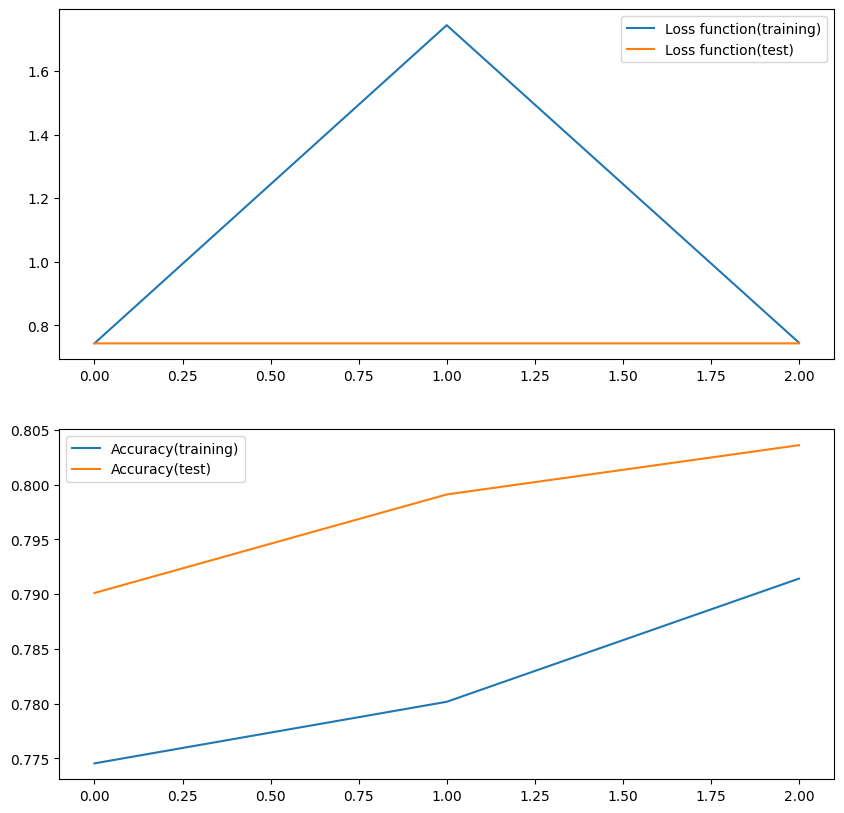

In [ ]:
# 75, 76
! rm ./checkpoint.csv


import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt


model = NN(300, 4)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.5)

train_losses = []
train_accuracy = []
test_losses = []
test_accuracy = []
with open(f'./checkpoint.csv', mode='a') as f:
    writer = csv.writer(f)
    writer.writerow(["EPOCH", "WEIGHT", "BIAS"])

for i in range(3):
  for x, y in loader:
      y_hat = model(x)
      loss = loss_fn(y_hat, y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
  with open(f'./checkpoint.csv', mode='a') as f:
    writer = csv.writer(f)
    writer.writerow([i, model.state_dict()['fc1.weight'], model.state_dict()['fc1.bias']])

  correct = 0
  num_train = 0

  for x, y in loader:
      y_hat = model(x)
      y_hat_max_index = torch.argmax(y_hat)
      y_max_index = torch.argmax(y)
      if y_hat_max_index == y_max_index:
        correct += 1
      num_train += 1
  train_losses.append(float(loss))
  train_accuracy.append(correct/num_train)
  optimizer.zero_grad()

  correct = 0
  num_test = 0

  for x, y in testloader:
      y_hat = model(x)
      y_hat_max_index = torch.argmax(y_hat)
      y_max_index = torch.argmax(y)
      if y_hat_max_index == y_max_index:
        correct += 1
      num_test += 1
      loss = loss_fn(y_hat, y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
  test_losses.append(float(loss))
  test_accuracy.append(correct/num_test)
  optimizer.zero_grad()
fig = plt.figure(figsize = (10,10))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.plot([i for i in range(len(train_losses))], train_losses, label="Loss function(training)")
ax1.plot([i for i in range(len(test_losses))], test_losses, label="Loss function(test)")
ax2.plot([i for i in range(len(train_accuracy))], train_accuracy, label="Accuracy(training)")
ax2.plot([i for i in range(len(test_accuracy))], test_accuracy, label="Accuracy(test)")
ax1.legend()
ax2.legend() # Google Colaboratoryでは動的なグラフ生成が手間なため割愛

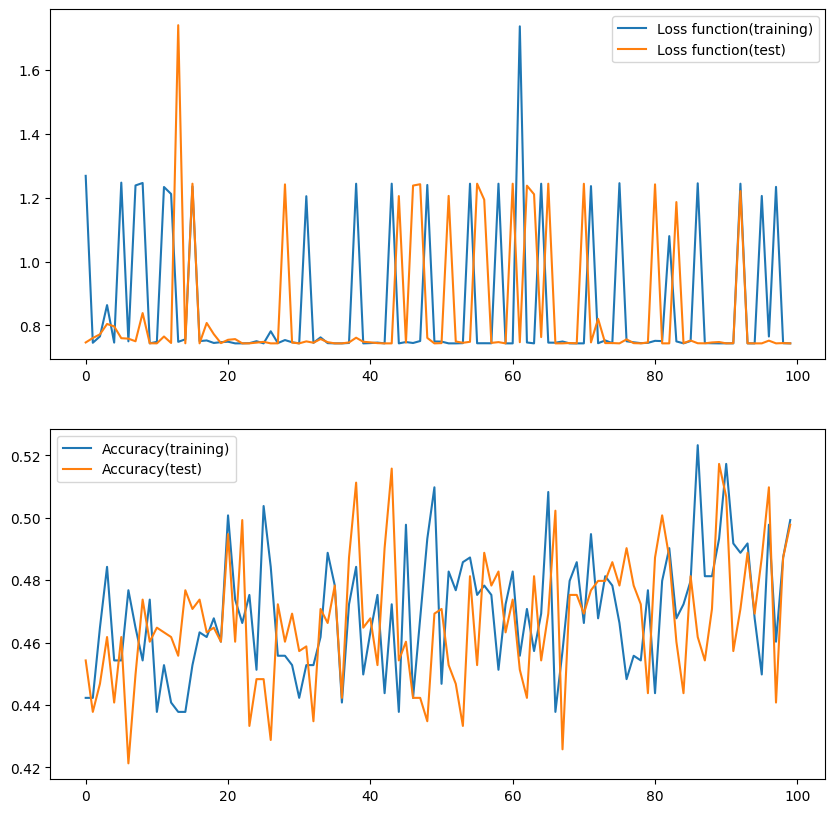

In [ ]:
# 77
! rm ./checkpoint.csv

batched_loader = DataLoader(dataset, batch_size=2, shuffle=True)

batched_testloader = DataLoader(test_dataset, batch_size=2, shuffle=True)

import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt


model = NN(300, 4)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.5)

train_losses = []
train_accuracy = []
test_losses = []
test_accuracy = []
with open(f'./checkpoint.csv', mode='a') as f:
    writer = csv.writer(f)
    writer.writerow(["EPOCH", "WEIGHT", "BIAS"])

for i in range(100):
  for x, y in batched_loader:
      y_hat = model(x)
      loss = loss_fn(y_hat, y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
  with open(f'./checkpoint.csv', mode='a') as f:
    writer = csv.writer(f)
    writer.writerow([i, model.state_dict()['fc1.weight'], model.state_dict()['fc1.bias']])

  correct = 0
  num_train = 0

  for x, y in batched_loader:
      y_hat = model(x)
      y_hat_max_index = torch.argmax(y_hat)
      y_max_index = torch.argmax(y)
      if y_hat_max_index == y_max_index:
        correct += 1
      num_train += 1
  train_losses.append(float(loss))
  train_accuracy.append(correct/num_train)
  optimizer.zero_grad()

  correct = 0
  num_test = 0

  for x, y in batched_testloader:
      y_hat = model(x)
      y_hat_max_index = torch.argmax(y_hat)
      y_max_index = torch.argmax(y)
      if y_hat_max_index == y_max_index:
        correct += 1
      num_test += 1
      loss = loss_fn(y_hat, y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
  test_losses.append(float(loss))
  test_accuracy.append(correct/num_test)
  optimizer.zero_grad()
fig = plt.figure(figsize = (10,10))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.plot([i for i in range(len(train_losses))], train_losses, label="Loss function(training)")
ax1.plot([i for i in range(len(test_losses))], test_losses, label="Loss function(test)")
ax2.plot([i for i in range(len(train_accuracy))], train_accuracy, label="Accuracy(training)")
ax2.plot([i for i in range(len(test_accuracy))], test_accuracy, label="Accuracy(test)")
ax1.legend()
ax2.legend() # Google Colaboratoryでは動的なグラフ生成が手間なため割愛

EPOCH 0
EPOCH 1
EPOCH 2
EPOCH 3
EPOCH 4
EPOCH 5
EPOCH 6
EPOCH 7
EPOCH 8
EPOCH 9
EPOCH 10
EPOCH 11
EPOCH 12
EPOCH 13
EPOCH 14
EPOCH 15
EPOCH 16
EPOCH 17
EPOCH 18
EPOCH 19
EPOCH 20
EPOCH 21
EPOCH 22
EPOCH 23
EPOCH 24
EPOCH 25
EPOCH 26
EPOCH 27
EPOCH 28
EPOCH 29
EPOCH 30
EPOCH 31
EPOCH 32
EPOCH 33
EPOCH 34
EPOCH 35
EPOCH 36
EPOCH 37
EPOCH 38
EPOCH 39
EPOCH 40
EPOCH 41
EPOCH 42
EPOCH 43
EPOCH 44
EPOCH 45
EPOCH 46
EPOCH 47
EPOCH 48
EPOCH 49
EPOCH 50
EPOCH 51
EPOCH 52
EPOCH 53
EPOCH 54
EPOCH 55
EPOCH 56
EPOCH 57
EPOCH 58
EPOCH 59
EPOCH 60
EPOCH 61
EPOCH 62
EPOCH 63
EPOCH 64
EPOCH 65
EPOCH 66
EPOCH 67
EPOCH 68
EPOCH 69
EPOCH 70
EPOCH 71
EPOCH 72
EPOCH 73
EPOCH 74
EPOCH 75
EPOCH 76
EPOCH 77
EPOCH 78
EPOCH 79
EPOCH 80
EPOCH 81
EPOCH 82
EPOCH 83
EPOCH 84
EPOCH 85
EPOCH 86
EPOCH 87
EPOCH 88
EPOCH 89
EPOCH 90
EPOCH 91
EPOCH 92
EPOCH 93
EPOCH 94
EPOCH 95
EPOCH 96
EPOCH 97
EPOCH 98
EPOCH 99


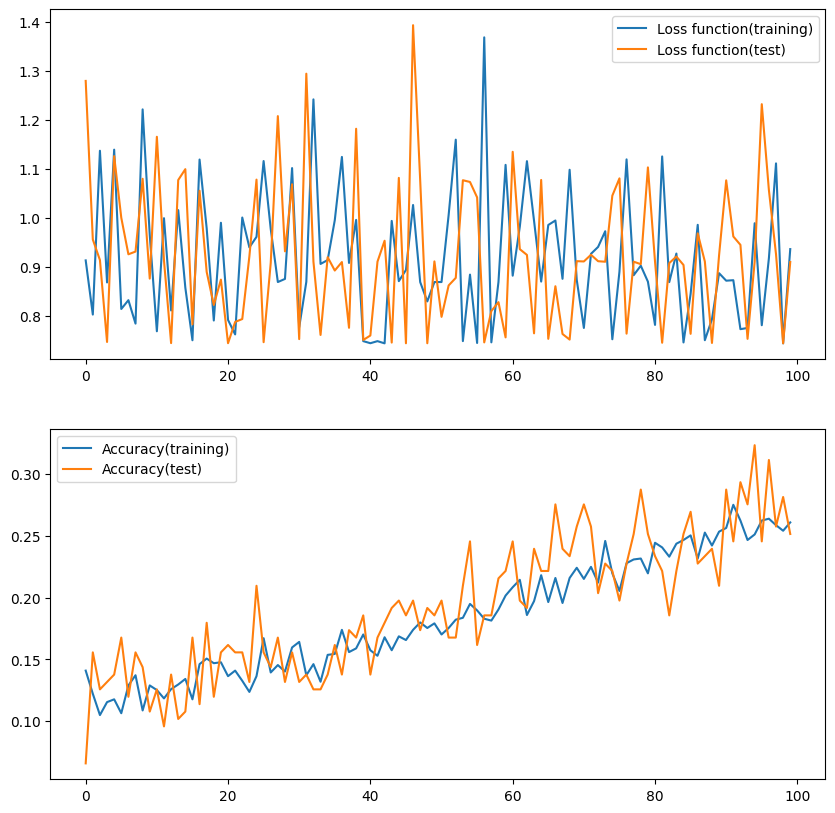

In [157]:
# 78 

import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

X_GPU = X.to('cuda')
Y_GPU = Y.to('cuda')
dataset = TensorDataset(X_GPU, Y_GPU)
loader = DataLoader(dataset, batch_size=8, shuffle=True)


test_X_GPU = test_X.to('cuda')
test_Y_GPU = test_Y.to('cuda')

test_dataset = TensorDataset(test_X_GPU, test_Y_GPU)
testloader = DataLoader(test_dataset, batch_size=8, shuffle=True)

model = NN(300, 4)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.5)
model.to('cuda')


train_losses = []
train_accuracy = []
test_losses = []
test_accuracy = []
with open(f'./checkpoint.csv', mode='a') as f:
    writer = csv.writer(f)
    writer.writerow(["EPOCH", "WEIGHT", "BIAS"])

for i in range(100):
  for x, y in loader:
      y_hat = model(x)
      loss = loss_fn(y_hat, y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
  with open(f'./checkpoint.csv', mode='a') as f:
    writer = csv.writer(f)
    writer.writerow([i, model.state_dict()['fc1.weight'], model.state_dict()['fc1.bias']])

  correct = 0
  num_train = 0

  for x, y in loader:
      y_hat = model(x)
      y_hat_max_index = torch.argmax(y_hat)
      y_max_index = torch.argmax(y)
      if y_hat_max_index == y_max_index:
        correct += 1
      num_train += 1
  train_losses.append(float(loss))
  train_accuracy.append(correct/num_train)
  optimizer.zero_grad()

  correct = 0
  num_test = 0

  for x, y in testloader:
      y_hat = model(x)
      y_hat_max_index = torch.argmax(y_hat)
      y_max_index = torch.argmax(y)
      if y_hat_max_index == y_max_index:
        correct += 1
      num_test += 1
      loss = loss_fn(y_hat, y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
  test_losses.append(float(loss))
  test_accuracy.append(correct/num_test)
  optimizer.zero_grad()
  print(f"EPOCH {i}")
fig = plt.figure(figsize = (10,10))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.plot([i for i in range(len(train_losses))], train_losses, label="Loss function(training)")
ax1.plot([i for i in range(len(test_losses))], test_losses, label="Loss function(test)")
ax2.plot([i for i in range(len(train_accuracy))], train_accuracy, label="Accuracy(training)")
ax2.plot([i for i in range(len(test_accuracy))], test_accuracy, label="Accuracy(test)")
ax1.legend()
ax2.legend() # Google Colaboratoryでは動的なグラフ生成が手間なため割愛

In [ ]:
print(X.shape, testX.shape)

rm: cannot remove './checkpoint.csv': No such file or directory
EPOCH 0
EPOCH 1
EPOCH 2
EPOCH 3
EPOCH 4
EPOCH 5
EPOCH 6
EPOCH 7
EPOCH 8
EPOCH 9
EPOCH 10
EPOCH 11
EPOCH 12
EPOCH 13
EPOCH 14
EPOCH 15
EPOCH 16
EPOCH 17
EPOCH 18
EPOCH 19
EPOCH 20
EPOCH 21
EPOCH 22
EPOCH 23
EPOCH 24
EPOCH 25
EPOCH 26
EPOCH 27
EPOCH 28
EPOCH 29
EPOCH 30
EPOCH 31
EPOCH 32
EPOCH 33
EPOCH 34
EPOCH 35
EPOCH 36
EPOCH 37
EPOCH 38
EPOCH 39
EPOCH 40
EPOCH 41
EPOCH 42
EPOCH 43
EPOCH 44
EPOCH 45
EPOCH 46
EPOCH 47
EPOCH 48
EPOCH 49
EPOCH 50
EPOCH 51
EPOCH 52
EPOCH 53
EPOCH 54
EPOCH 55
EPOCH 56
EPOCH 57
EPOCH 58
EPOCH 59
EPOCH 60
EPOCH 61
EPOCH 62
EPOCH 63
EPOCH 64
EPOCH 65
EPOCH 66
EPOCH 67
EPOCH 68
EPOCH 69
EPOCH 70
EPOCH 71
EPOCH 72
EPOCH 73
EPOCH 74
EPOCH 75
EPOCH 76
EPOCH 77
EPOCH 78
EPOCH 79
EPOCH 80
EPOCH 81
EPOCH 82
EPOCH 83
EPOCH 84
EPOCH 85
EPOCH 86
EPOCH 87
EPOCH 88
EPOCH 89
EPOCH 90
EPOCH 91
EPOCH 92
EPOCH 93
EPOCH 94
EPOCH 95
EPOCH 96
EPOCH 97
EPOCH 98
EPOCH 99


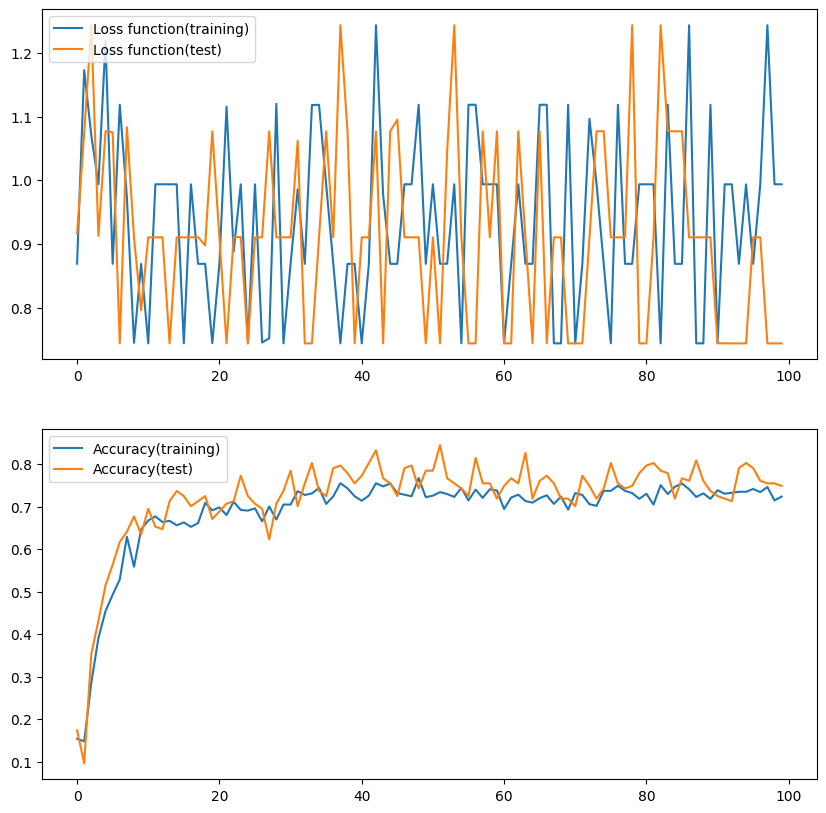

In [148]:
#79
! rm ./checkpoint.csv
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt


class multi_NN(nn.Module):
    def __init__(self):
        super(multi_NN, self).__init__()
        self.fc1 = nn.Linear(300, 100)
        self.dropout = nn.Dropout(0.1) 
        self.fc2 = nn.Linear(100, 30)
        self.fc3 = nn.Linear(30, 4)
        

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x

X_GPU = X.to('cuda')
Y_GPU = Y.to('cuda')
dataset = TensorDataset(X_GPU, Y_GPU)
loader = DataLoader(dataset, batch_size=8, shuffle=True)


test_X_GPU = test_X.to('cuda')
test_Y_GPU = test_Y.to('cuda')

test_dataset = TensorDataset(test_X_GPU, test_Y_GPU)
testloader = DataLoader(test_dataset, batch_size=8, shuffle=True)

model = multi_NN()
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.5)
model.to('cuda')


train_losses = []
train_accuracy = []
test_losses = []
test_accuracy = []
with open(f'./checkpoint.csv', mode='a') as f:
    writer = csv.writer(f)
    writer.writerow(["EPOCH", "WEIGHT1", "BIAS1"])

for i in range(100):
  for x, y in loader:
      y_hat = model(x)
      loss = loss_fn(y_hat, y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
  with open(f'./checkpoint.csv', mode='a') as f:
    writer = csv.writer(f)
    writer.writerow([i, model.state_dict()['fc1.weight'], model.state_dict()['fc1.bias']])

  correct = 0
  num_train = 0

  for x, y in loader:
      y_hat = model(x)
      y_hat_max_index = torch.argmax(y_hat)
      y_max_index = torch.argmax(y)
      if y_hat_max_index == y_max_index:
        correct += 1
      num_train += 1
  train_losses.append(float(loss))
  train_accuracy.append(correct/num_train)
  optimizer.zero_grad()

  correct = 0
  num_test = 0

  for x, y in testloader:
      y_hat = model(x)
      y_hat_max_index = torch.argmax(y_hat)
      y_max_index = torch.argmax(y)
      if y_hat_max_index == y_max_index:
        correct += 1
      num_test += 1
      loss = loss_fn(y_hat, y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
  test_losses.append(float(loss))
  test_accuracy.append(correct/num_test)
  optimizer.zero_grad()
  print(f"EPOCH {i}")
fig = plt.figure(figsize = (10,10))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
ax1.plot([i for i in range(len(train_losses))], train_losses, label="Loss function(training)")
ax1.plot([i for i in range(len(test_losses))], test_losses, label="Loss function(test)")
ax2.plot([i for i in range(len(train_accuracy))], train_accuracy, label="Accuracy(training)")
ax2.plot([i for i in range(len(test_accuracy))], test_accuracy, label="Accuracy(test)")
ax1.legend()
ax2.legend() # Google Colaboratoryでは動的なグラフ生成が手間なため割愛